# Dadi Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the dadi optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and results.

In [2]:
# Define base paths
base_path = Path('/sietch_colab/akapoor/Infer_Demography/experiments/split_isolation')
simulations_path = base_path / 'simulations'
runs_path = base_path / 'runs'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Runs path: {runs_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Runs: {runs_path.exists()}")

Base path: /sietch_colab/akapoor/Infer_Demography/experiments/split_isolation
Simulations path: /sietch_colab/akapoor/Infer_Demography/experiments/split_isolation/simulations
Runs path: /sietch_colab/akapoor/Infer_Demography/experiments/split_isolation/runs

Paths exist:
Simulations: True
Runs: True


## Load Simulation Data and Ground Truth

Read ground truth parameter values from the simulations directory structure.

In [3]:
def load_ground_truth_parameters():
    """Load ground truth parameters from all simulation directories."""
    ground_truth = {}
    
    # Find all simulation directories
    sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()], 
                     key=lambda x: int(x.name))
    
    print(f"Found {len(sim_dirs)} simulation directories")
    
    for sim_dir in sim_dirs:
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                ground_truth[sim_id] = params
                if int(sim_id) % 100 == 0:  # Print progress every 100 simulations
                    print(f"Loaded ground truth for simulation {sim_id}")
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
        else:
            if int(sim_id) < 10:  # Only warn for first few missing files
                print(f"Parameter file not found: {param_file}")
    
    return ground_truth

# Load ground truth parameters for all simulations
ground_truth_params = load_ground_truth_parameters()

# Display structure of ground truth data
if ground_truth_params:
    first_sim = list(ground_truth_params.keys())[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    for key, value in ground_truth_params[first_sim].items():
        print(f"  {key}: {value}")
    
    print(f"\nLoaded ground truth for {len(ground_truth_params)} simulations: {min(ground_truth_params.keys(), key=int)} - {max(ground_truth_params.keys(), key=int)}")
else:
    print("No ground truth parameters loaded!")

Found 20 simulation directories
Loaded ground truth for simulation 0

Example parameters for simulation 0:
  N0: 26163.470229605657
  N1: 15364.161654954836
  N2: 19289.44542279145
  m: 6.927038449408985e-05
  t_split: 18161.544834397115

Loaded ground truth for 20 simulations: 0 - 19


## Load Dadi Best Fit Results

Load the dadi optimization results for each run, including parameter estimates and likelihood values.

In [4]:
def load_dadi_results():
    """Load dadi best fit results from run directories for all simulations."""
    dadi_results = {}
    
    # Search for dadi result files in run directories
    run_dirs = sorted(runs_path.glob('run_*_*'))
    
    print(f"Found {len(run_dirs)} run directories")
    print("Loading dadi results for all simulations...")
    
    for run_dir in run_dirs:
        if run_dir.is_dir():
            run_name = run_dir.name
            
            # Parse run name to get simulation ID and replicate ID
            parts = run_name.split('_')
            if len(parts) >= 3:
                sim_id = parts[1]
                rep_id = parts[2]
                
                # Look for dadi output files
                possible_files = [
                    run_dir / 'inferences/dadi/fit_params.pkl',
                    run_dir / 'inferences/dadi/best_fit.pkl',
                    run_dir / 'optimization_results.pkl',
                    run_dir / 'dadi_results.pkl',
                    run_dir / 'results.pkl'
                ]
                
                result_file = None
                for pf in possible_files:
                    if pf.exists():
                        result_file = pf
                        break
                
                if result_file:
                    try:
                        with open(result_file, 'rb') as f:
                            results = pickle.load(f)
                        
                        if sim_id not in dadi_results:
                            dadi_results[sim_id] = {}
                        
                        dadi_results[sim_id][rep_id] = {
                            'results': results,
                            'file': result_file
                        }
                        
                        # Progress update
                        if int(sim_id) % 100 == 0 and rep_id == '0':
                            print(f"Loading simulation {sim_id}...")
                        
                    except Exception as e:
                        if int(sim_id) < 10:  # Only show errors for first few sims
                            print(f"Error loading {result_file}: {e}")
    
    return dadi_results

# Load dadi results for all simulations
dadi_results = load_dadi_results()

# Display summary of loaded results
print(f"\nLoaded dadi results for {len(dadi_results)} simulations")
if dadi_results:
    sim_ids_sorted = sorted(dadi_results.keys(), key=int)
    print(f"Simulation range: {sim_ids_sorted[0]} - {sim_ids_sorted[-1]}")
    
    # Show replicate counts for first few and last few simulations
    print("\nReplicate counts for first 5 simulations:")
    for sim_id in sim_ids_sorted[:5]:
        print(f"  Simulation {sim_id}: {len(dadi_results[sim_id])} replicates")
    
    if len(sim_ids_sorted) > 10:
        print("\nReplicate counts for last 5 simulations:")
        for sim_id in sim_ids_sorted[-5:]:
            print(f"  Simulation {sim_id}: {len(dadi_results[sim_id])} replicates")

# Show structure of first result if available
if dadi_results:
    first_sim = sorted(dadi_results.keys(), key=int)[0]
    first_rep = list(dadi_results[first_sim].keys())[0]
    first_result = dadi_results[first_sim][first_rep]['results']
    print(f"\nExample result structure for sim {first_sim}, rep {first_rep}:")
    if isinstance(first_result, dict):
        for key in first_result.keys():
            print(f"  {key}: {type(first_result[key])}")
    else:
        print(f"  Result type: {type(first_result)}")

Found 20 run directories
Loading dadi results for all simulations...
Loading simulation 0...

Loaded dadi results for 20 simulations
Simulation range: 0 - 19

Replicate counts for first 5 simulations:
  Simulation 0: 1 replicates
  Simulation 1: 1 replicates
  Simulation 2: 1 replicates
  Simulation 3: 1 replicates
  Simulation 4: 1 replicates

Replicate counts for last 5 simulations:
  Simulation 15: 1 replicates
  Simulation 16: 1 replicates
  Simulation 17: 1 replicates
  Simulation 18: 1 replicates
  Simulation 19: 1 replicates

Example result structure for sim 0, rep 0:
  mode: <class 'str'>
  best_params: <class 'dict'>
  best_ll: <class 'float'>
  param_order: <class 'list'>
  fixed_params: <class 'dict'>


## Explore Data Structure

Let's examine the actual file structure to understand how the data is organized.

In [5]:
# Let's explore the actual directory structure for all simulations
print("Examining run directory structure...")

# Check a sample of run directories
all_runs = [d for d in runs_path.glob('run_*_*')]
sample_runs = all_runs[:5]  # Show first 5 runs

for run_dir in sample_runs:
    print(f"\n{run_dir.name}:")
    files = sorted(run_dir.glob('**/*'), key=lambda x: str(x))  # Recursive glob
    for f in files[:10]:  # Limit output
        if f.is_file():
            size = f.stat().st_size
            rel_path = f.relative_to(run_dir)
            print(f"  {rel_path} ({size} bytes)")
        else:
            rel_path = f.relative_to(run_dir)
            print(f"  {rel_path}/ (directory)")

# Also check simulation directory structure
print(f"\n\nExamining simulation directory structure (total: {len(list(simulations_path.glob('*')))} directories)...")
sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()], 
                 key=lambda x: int(x.name))

for sim_dir in sim_dirs[:3]:  # Show first 3
    print(f"\n{sim_dir.name}:")
    files = sorted(sim_dir.glob('*'))
    for f in files:
        if f.is_file():
            size = f.stat().st_size
            print(f"  {f.name} ({size} bytes)")
        else:
            print(f"  {f.name}/ (directory)")

Examining run directory structure...

run_19_0:
  inferences/ (directory)
  inferences/dadi/ (directory)
  inferences/dadi/best_fit.pkl (186 bytes)
  inferences/dadi/fit_params.pkl (186 bytes)
  inferences/dadi/likelihood_profiles/ (directory)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_N0.png (49482 bytes)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_N1.png (55081 bytes)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_N2.png (60940 bytes)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_m.png (54967 bytes)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_t_split.png (62042 bytes)

run_16_0:
  inferences/ (directory)
  inferences/dadi/ (directory)
  inferences/dadi/best_fit.pkl (186 bytes)
  inferences/dadi/fit_params.pkl (186 bytes)
  inferences/dadi/likelihood_profiles/ (directory)
  inferences/dadi/likelihood_profiles/likelihood_profile_dadi_N0.png (59146 bytes)
  inferences/dadi/likelihood_profiles/likelihoo

## Create Data Loading Functions (Updated)

Based on the actual file structure, let's create more specific loading functions.

In [6]:
def extract_parameters_from_results(results_data):
    """Extract parameter values from dadi results data structure."""
    params = {}
    
    # Debug: show the structure of the first few results
    if not hasattr(extract_parameters_from_results, 'debug_shown'):
        print(f"Debug: results_data type = {type(results_data)}")
        if isinstance(results_data, dict):
            print(f"Debug: results_data keys = {list(results_data.keys())}")
            for key, value in list(results_data.items())[:3]:  # Show first 3 items
                print(f"  {key}: {type(value)} = {value}")
        elif isinstance(results_data, (list, tuple, np.ndarray)):
            print(f"Debug: results_data length = {len(results_data)}")
            print(f"Debug: first few values = {results_data[:5] if len(results_data) > 5 else results_data}")
        extract_parameters_from_results.debug_shown = True
    
    # This function will need to be adapted based on your actual dadi output format
    # Common dadi result formats include:
    
    if isinstance(results_data, dict):
        # If it's a dictionary, look for common parameter keys
        param_keys = ['best_params', 'optimal_params', 'parameters', 'theta', 'params']
        
        for key in param_keys:
            if key in results_data:
                params = results_data[key]
                break
        
        # Also look for likelihood
        ll_keys = ['best_ll', 'likelihood', 'll', 'log_likelihood']
        for key in ll_keys:
            if key in results_data:
                if isinstance(params, dict):
                    params['log_likelihood'] = results_data[key]
                else:
                    # If params is not a dict yet, make it one
                    if isinstance(params, (list, tuple, np.ndarray)):
                        param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']  # Adjust based on your model
                        if len(params) == len(param_names):
                            params = dict(zip(param_names, params))
                        else:
                            params = {f'param_{i}': val for i, val in enumerate(params)}
                    params['log_likelihood'] = results_data[key]
                break
    
    elif isinstance(results_data, (list, tuple, np.ndarray)):
        # If it's an array, assume it's parameter values
        # You'll need to map these to parameter names based on your model
        param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']  # Adjust based on your model
        
        if len(results_data) == len(param_names):
            params = dict(zip(param_names, results_data))
        else:
            # If length doesn't match, use generic names
            params = {f'param_{i}': val for i, val in enumerate(results_data)}
    
    return params

def find_best_estimates_per_simulation(dadi_results):
    """Find the highest likelihood estimate for each simulation across all replicates."""
    best_estimates = {}
    
    print("Finding best estimates per simulation...")
    
    for sim_id, replicates in dadi_results.items():
        best_ll = -np.inf
        best_params = None
        best_rep = None
        
        print(f"Processing simulation {sim_id} with {len(replicates)} replicates...")
        
        for rep_id, rep_data in replicates.items():
            # Extract parameters and likelihood
            params = extract_parameters_from_results(rep_data['results'])
            
            print(f"  Rep {rep_id}: extracted params type = {type(params)}")
            if isinstance(params, dict):
                print(f"    Keys: {list(params.keys())}")
            
            # Get likelihood (try different possible keys)
            likelihood = None
            if isinstance(params, dict):
                for ll_key in ['log_likelihood', 'likelihood', 'll', 'best_lls']:
                    if ll_key in params:
                        likelihood = params[ll_key]
                        print(f"    Found likelihood under key '{ll_key}': {likelihood}")
                        break
                
                if likelihood is None:
                    print(f"    No likelihood found in keys: {list(params.keys())}")
            
            # If we found a likelihood and it's better than current best
            if likelihood is not None and likelihood > best_ll:
                best_ll = likelihood
                best_params = params
                best_rep = rep_id
                print(f"    New best for sim {sim_id}: rep {rep_id}, ll = {best_ll}")
        
        if best_params is not None:
            best_estimates[sim_id] = {
                'parameters': best_params,
                'log_likelihood': best_ll,
                'best_replicate': best_rep
            }
            print(f"  Final best for sim {sim_id}: rep {best_rep}, ll = {best_ll}")
        else:
            print(f"  No valid estimates found for simulation {sim_id}")
        
        # Only process first few simulations for debugging
        if int(sim_id) >= 3:
            print(f"  (Skipping detailed output for remaining simulations...)")
            # Continue processing but don't print details
            for rep_id, rep_data in replicates.items():
                params = extract_parameters_from_results(rep_data['results'])
                likelihood = None
                if isinstance(params, dict):
                    for ll_key in ['log_likelihood', 'likelihood', 'll', 'best_lls']:
                        if ll_key in params:
                            likelihood = params[ll_key]
                            break
                
                if likelihood is not None and likelihood > best_ll:
                    best_ll = likelihood
                    best_params = params
                    best_rep = rep_id
            
            if best_params is not None:
                best_estimates[sim_id] = {
                    'parameters': best_params,
                    'log_likelihood': best_ll,
                    'best_replicate': best_rep
                }
    
    print(f"Found best estimates for {len(best_estimates)} simulations")
    return best_estimates

def create_comparison_dataframe(ground_truth_params, best_estimates):
    """Create a DataFrame comparing ground truth vs best estimated parameters."""
    comparison_data = []
    
    for sim_id in ground_truth_params.keys():
        if sim_id in best_estimates:
            gt_params = ground_truth_params[sim_id]
            best_est = best_estimates[sim_id]
            est_params = best_est['parameters']
            
            # Create a row for each parameter
            for param_name in gt_params.keys():
                if param_name in est_params:
                    comparison_data.append({
                        'simulation': sim_id,
                        'best_replicate': best_est['best_replicate'],
                        'parameter': param_name,
                        'ground_truth': gt_params[param_name],
                        'estimated': est_params[param_name],
                        'log_likelihood': best_est['log_likelihood'],
                        'relative_error': (est_params[param_name] - gt_params[param_name]) / gt_params[param_name] if gt_params[param_name] != 0 else np.nan
                    })
    
    return pd.DataFrame(comparison_data)

# Find best estimates across all replicates for each simulation
if ground_truth_params and dadi_results:
    best_estimates = find_best_estimates_per_simulation(dadi_results)
    
    # Create comparison DataFrame using best estimates only
    df_comparison = create_comparison_dataframe(ground_truth_params, best_estimates)
    
    if len(df_comparison) > 0:
        print(f"\nCreated comparison DataFrame with {len(df_comparison)} rows")
        print(f"Simulations with data: {len(df_comparison['simulation'].unique())}")
        print(f"Parameters found: {df_comparison['parameter'].unique()}")
        print(f"\nFirst few rows:")
        print(df_comparison.head())
    else:
        print("\nWarning: Created empty comparison DataFrame!")
        print(f"Ground truth simulations: {len(ground_truth_params)}")
        print(f"Best estimates found: {len(best_estimates)}")
        
        # Debug: show what simulations we have
        if len(ground_truth_params) > 0:
            gt_sims = sorted(ground_truth_params.keys(), key=lambda x: int(x))
            print(f"Ground truth simulation range: {gt_sims[0]} - {gt_sims[-1]}")
        
        if len(best_estimates) > 0:
            be_sims = sorted(best_estimates.keys(), key=lambda x: int(x))
            print(f"Best estimates simulation range: {be_sims[0]} - {be_sims[-1]}")
            
            # Check overlap
            common_sims = set(ground_truth_params.keys()) & set(best_estimates.keys())
            print(f"Common simulations: {len(common_sims)}")
            if len(common_sims) > 0:
                print(f"Sample common simulation: {list(common_sims)[0]}")
                # Check data structure for debugging
                sample_sim = list(common_sims)[0]
                print(f"Ground truth keys: {list(ground_truth_params[sample_sim].keys())}")
                print(f"Best estimate keys: {list(best_estimates[sample_sim]['parameters'].keys())}")
        
        df_comparison = pd.DataFrame()  # Create empty DataFrame to avoid further errors
else:
    print("Cannot create comparison DataFrame - missing ground truth or dadi results")

Finding best estimates per simulation...
Processing simulation 0 with 1 replicates...
Debug: results_data type = <class 'dict'>
Debug: results_data keys = ['mode', 'best_params', 'best_ll', 'param_order', 'fixed_params']
  mode: <class 'str'> = dadi
  best_params: <class 'dict'> = {'N0': 25366.22418711487, 'N1': 14725.652287338637, 'N2': 19795.463304122026, 'm': 7.307311286752576e-05, 't_split': 20000.000000000004}
  best_ll: <class 'float'> = 442823.80919622735
  Rep 0: extracted params type = <class 'dict'>
    Keys: ['N0', 'N1', 'N2', 'm', 't_split', 'log_likelihood']
    Found likelihood under key 'log_likelihood': 442823.80919622735
    New best for sim 0: rep 0, ll = 442823.80919622735
  Final best for sim 0: rep 0, ll = 442823.80919622735
Processing simulation 10 with 1 replicates...
  Rep 0: extracted params type = <class 'dict'>
    Keys: ['N0', 'N1', 'N2', 'm', 't_split', 'log_likelihood']
    Found likelihood under key 'log_likelihood': 163942.57793682726
    New best for si

## Plot Best Fit vs Ground Truth Comparison

Create scatter plots comparing estimated parameters against true parameter values.

### Analysis Configuration

In [7]:
# Analysis configuration
MAX_SIMS_TO_PLOT = 100  # Set to a number (e.g., 10) to limit simulations plotted, or None for all
RANDOM_SUBSET = False    # If True and MAX_SIMS_TO_PLOT is set, randomly sample simulations

print(f"Analysis configuration:")
print(f"  Max simulations to plot: {MAX_SIMS_TO_PLOT}")
print(f"  Use random subset: {RANDOM_SUBSET}")

Analysis configuration:
  Max simulations to plot: 100
  Use random subset: False


Analysis functions defined successfully!


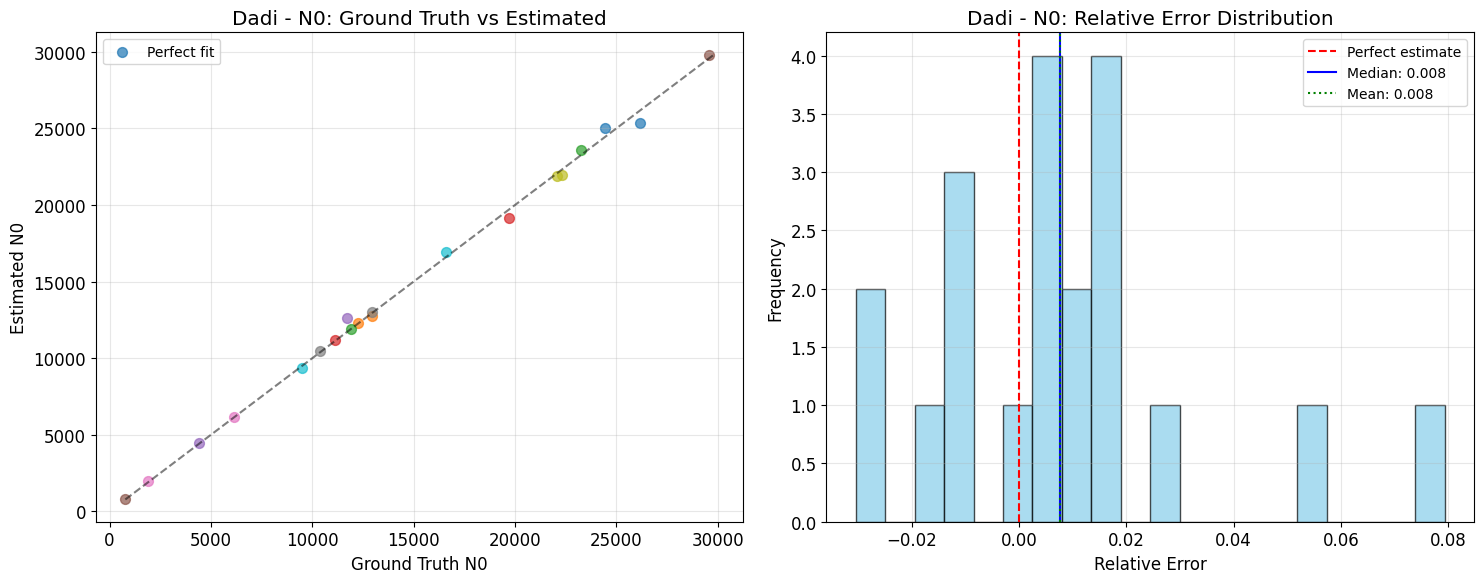


Dadi Summary for N0:
  Number of estimates: 20
  Correlation coefficient: 0.9990
  Mean relative error: 0.0077
  Median relative error: 0.0076
  Std relative error: 0.0255
  RMSE: 368.8321


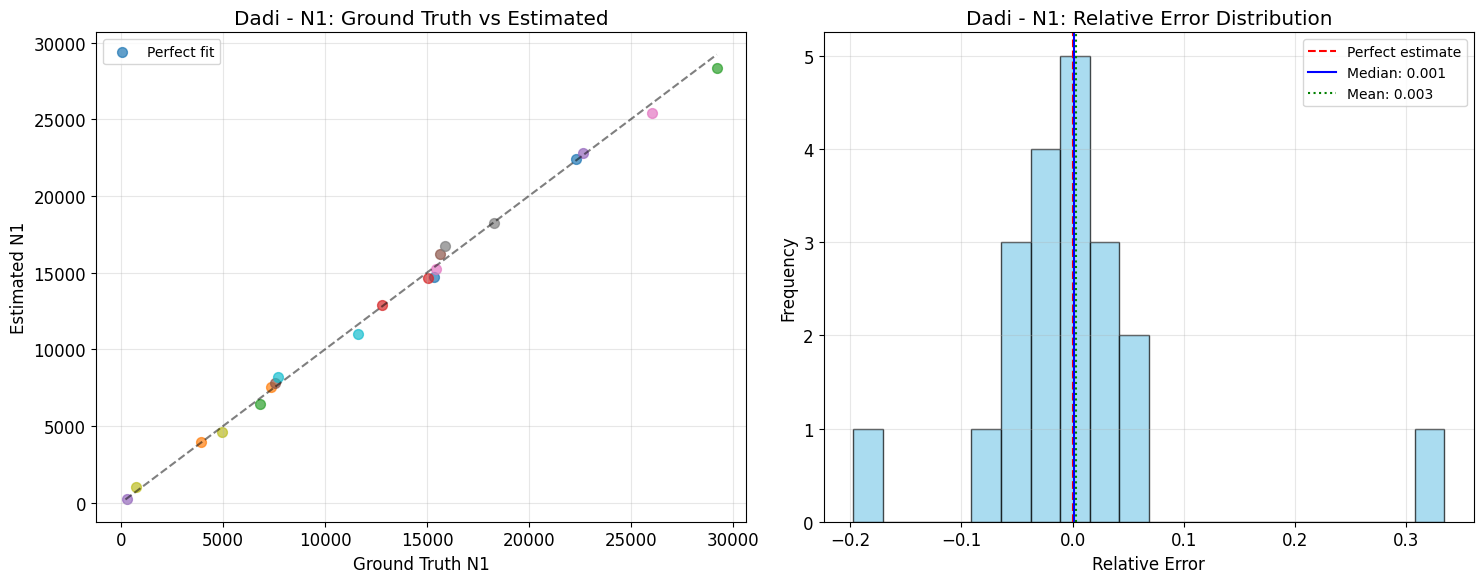


Dadi Summary for N1:
  Number of estimates: 20
  Correlation coefficient: 0.9986
  Mean relative error: 0.0032
  Median relative error: 0.0012
  Std relative error: 0.0964
  RMSE: 440.0501


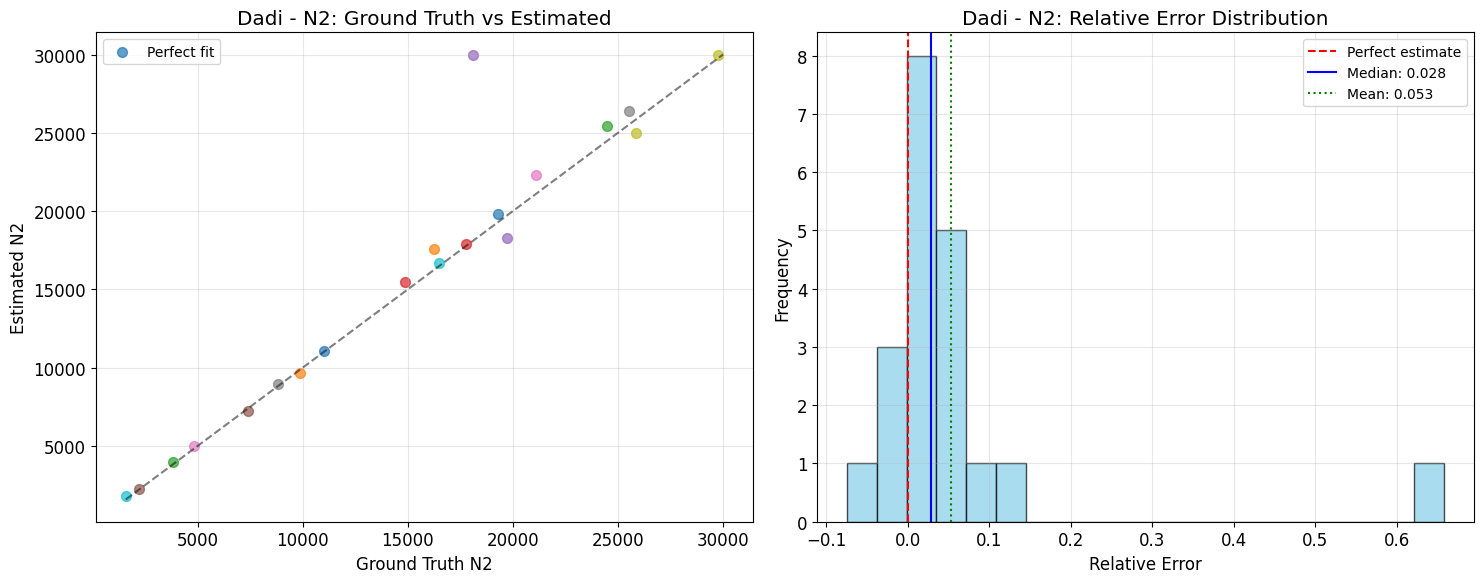


Dadi Summary for N2:
  Number of estimates: 20
  Correlation coefficient: 0.9561
  Mean relative error: 0.0531
  Median relative error: 0.0280
  Std relative error: 0.1489
  RMSE: 2742.8347


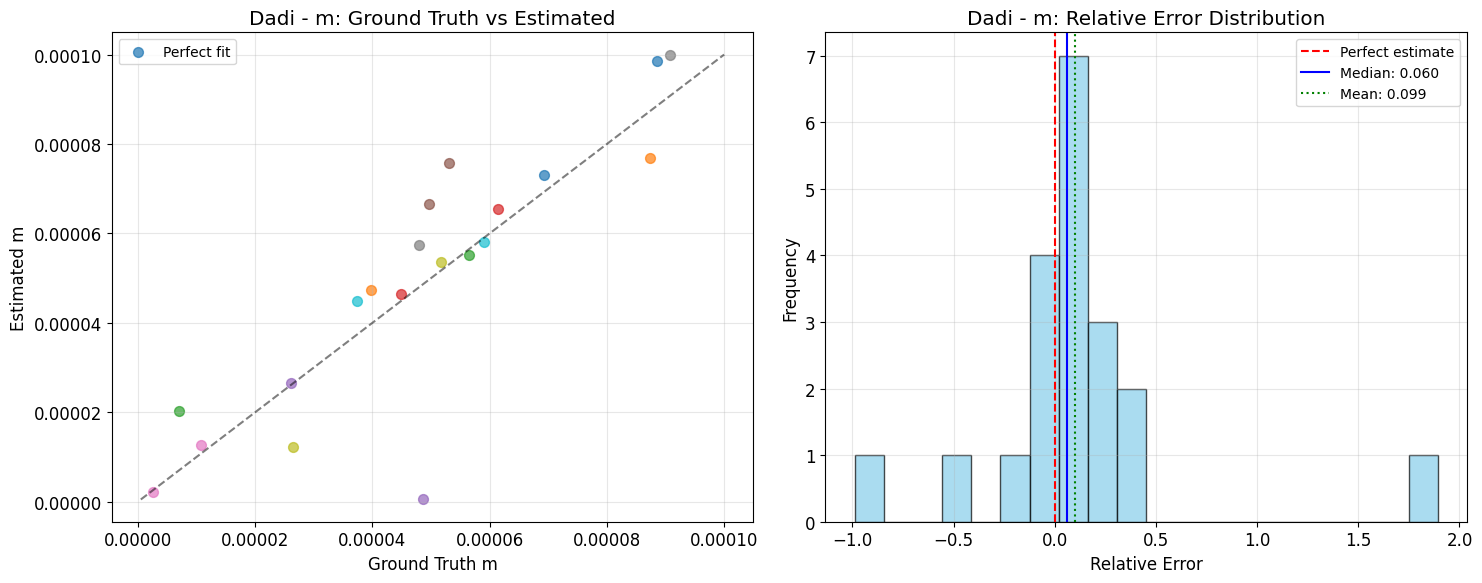


Dadi Summary for m:
  Number of estimates: 20
  Correlation coefficient: 0.8712
  Mean relative error: 0.0991
  Median relative error: 0.0596
  Std relative error: 0.5213
  RMSE: 0.0000


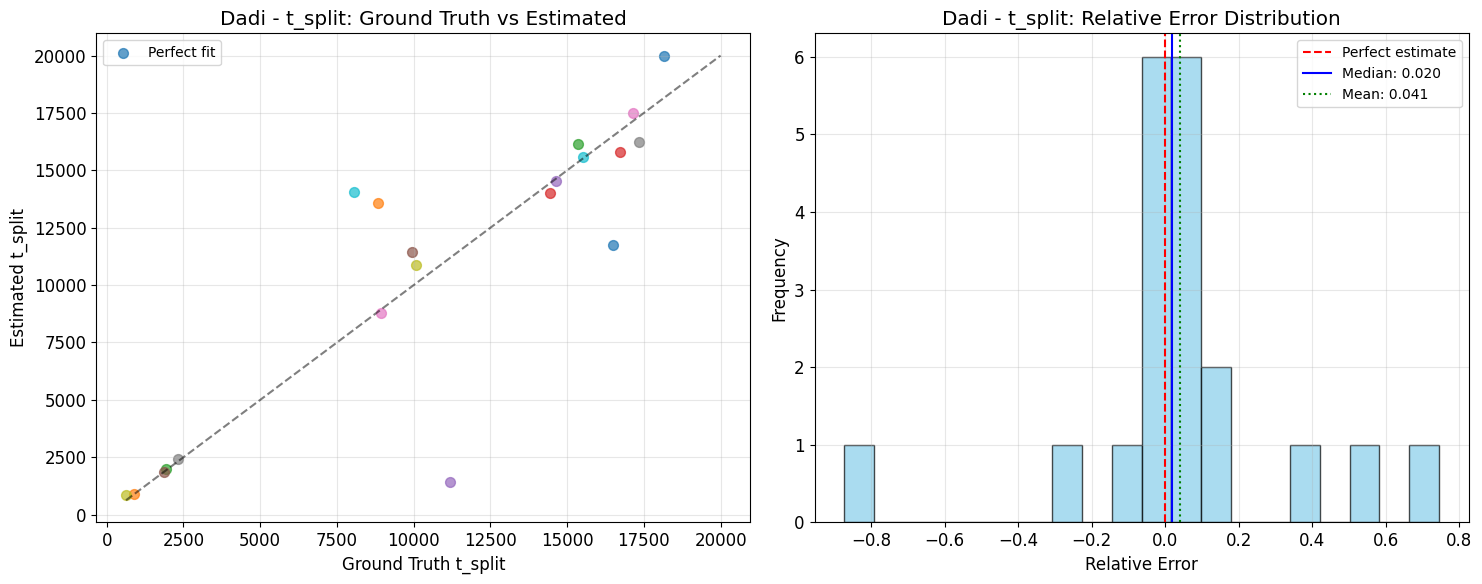


Dadi Summary for t_split:
  Number of estimates: 20
  Correlation coefficient: 0.8783
  Mean relative error: 0.0407
  Median relative error: 0.0196
  Std relative error: 0.3126
  RMSE: 3049.8732


In [8]:
def plot_parameter_comparison(df, parameter_name, title_prefix="Dadi", max_sims=None, random_subset=False):
    """Plot ground truth vs estimated values for a specific parameter."""
    param_data = df[(df['parameter'] == parameter_name) & (df['parameter'] != 'log_likelihood')]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return None
    
    # Filter simulations if requested
    unique_sims = sorted(param_data['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        param_data = param_data[param_data['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Plotting {len(unique_sims)} of {len(sorted(df[df['parameter'] == parameter_name]['simulation'].unique()))} simulations for {parameter_name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Ground truth vs Estimated
    ax1 = axes[0]
    
    # Color by simulation
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sims)))
    
    for i, sim_id in enumerate(unique_sims):
        sim_data = param_data[param_data['simulation'] == sim_id]
        ax1.scatter(sim_data['ground_truth'], sim_data['estimated'], 
                   label=f'Sim {sim_id}', alpha=0.7, s=50, color=colors[i])
    
    # Add identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {parameter_name}')
    ax1.set_ylabel(f'Estimated {parameter_name}')
    ax1.set_title(f'{title_prefix} - {parameter_name}: Ground Truth vs Estimated')
    ax1.grid(True, alpha=0.3)
    
    # Always show legend, but position it appropriately
    if len(unique_sims) <= 15:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    else:
        # For many simulations, just show Perfect fit line in legend
        ax1.legend(['Perfect fit'], loc='best', fontsize=10)
    
    # Relative error histogram
    ax2 = axes[1]
    valid_errors = param_data['relative_error'].dropna()
    
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
        ax2.axvline(valid_errors.mean(), color='green', linestyle=':', 
                   label=f'Mean: {valid_errors.mean():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{title_prefix} - {parameter_name}: Relative Error Distribution')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated', 'relative_error'])
    if len(valid_data) > 0:
        # Calculate absolute error for RMSE
        valid_data = valid_data.copy()
        valid_data['absolute_error'] = valid_data['estimated'] - valid_data['ground_truth']
        
        correlation = valid_data['ground_truth'].corr(valid_data['estimated'])
        print(f"\n{title_prefix} Summary for {parameter_name}:")
        print(f"  Number of estimates: {len(valid_data)}")
        print(f"  Correlation coefficient: {correlation:.4f}")
        print(f"  Mean relative error: {valid_data['relative_error'].mean():.4f}")
        print(f"  Median relative error: {valid_data['relative_error'].median():.4f}")
        print(f"  Std relative error: {valid_data['relative_error'].std():.4f}")
        print(f"  RMSE: {np.sqrt((valid_data['absolute_error']**2).mean()):.4f}")
    
    return fig

def calculate_parameter_statistics(df, title_prefix="Dadi"):
    """Calculate comprehensive statistics for parameter estimates."""
    stats_results = []
    
    # Exclude log_likelihood from analysis
    param_df = df[df['parameter'] != 'log_likelihood']
    
    for param in param_df['parameter'].unique():
        param_data = param_df[param_df['parameter'] == param]
        
        for sim_id in param_data['simulation'].unique():
            sim_data = param_data[param_data['simulation'] == sim_id]
            valid_data = sim_data.dropna(subset=['ground_truth', 'estimated'])
            
            if len(valid_data) == 0:
                continue
                
            gt_value = valid_data['ground_truth'].iloc[0]
            estimates = valid_data['estimated']
            
            stats_results.append({
                'parameter': param,
                'simulation': sim_id,
                'ground_truth': gt_value,
                'mean_estimate': estimates.mean(),
                'median_estimate': estimates.median(),
                'std_estimate': estimates.std(),
                'bias': estimates.mean() - gt_value,
                'relative_bias': (estimates.mean() - gt_value) / gt_value if gt_value != 0 else np.nan,
                'rmse': np.sqrt(((estimates - gt_value) ** 2).mean()),
                'relative_rmse': np.sqrt(((estimates - gt_value) ** 2).mean()) / abs(gt_value) if gt_value != 0 else np.nan,
                'n_replicates': len(estimates)
            })
    
    return pd.DataFrame(stats_results)

print("Analysis functions defined successfully!")

# Plot comparisons for all parameters using configuration settings
if 'df_comparison' in locals() and not df_comparison.empty:
    for param in df_comparison['parameter'].unique():
        plot_parameter_comparison(df_comparison, param, 
                                max_sims=MAX_SIMS_TO_PLOT, 
                                random_subset=RANDOM_SUBSET)
else:
    print("No comparison data available for plotting")

## Create Parameter Histograms for Each Simulation

Generate histograms showing the distribution of best fit parameters across replicates for each simulation.

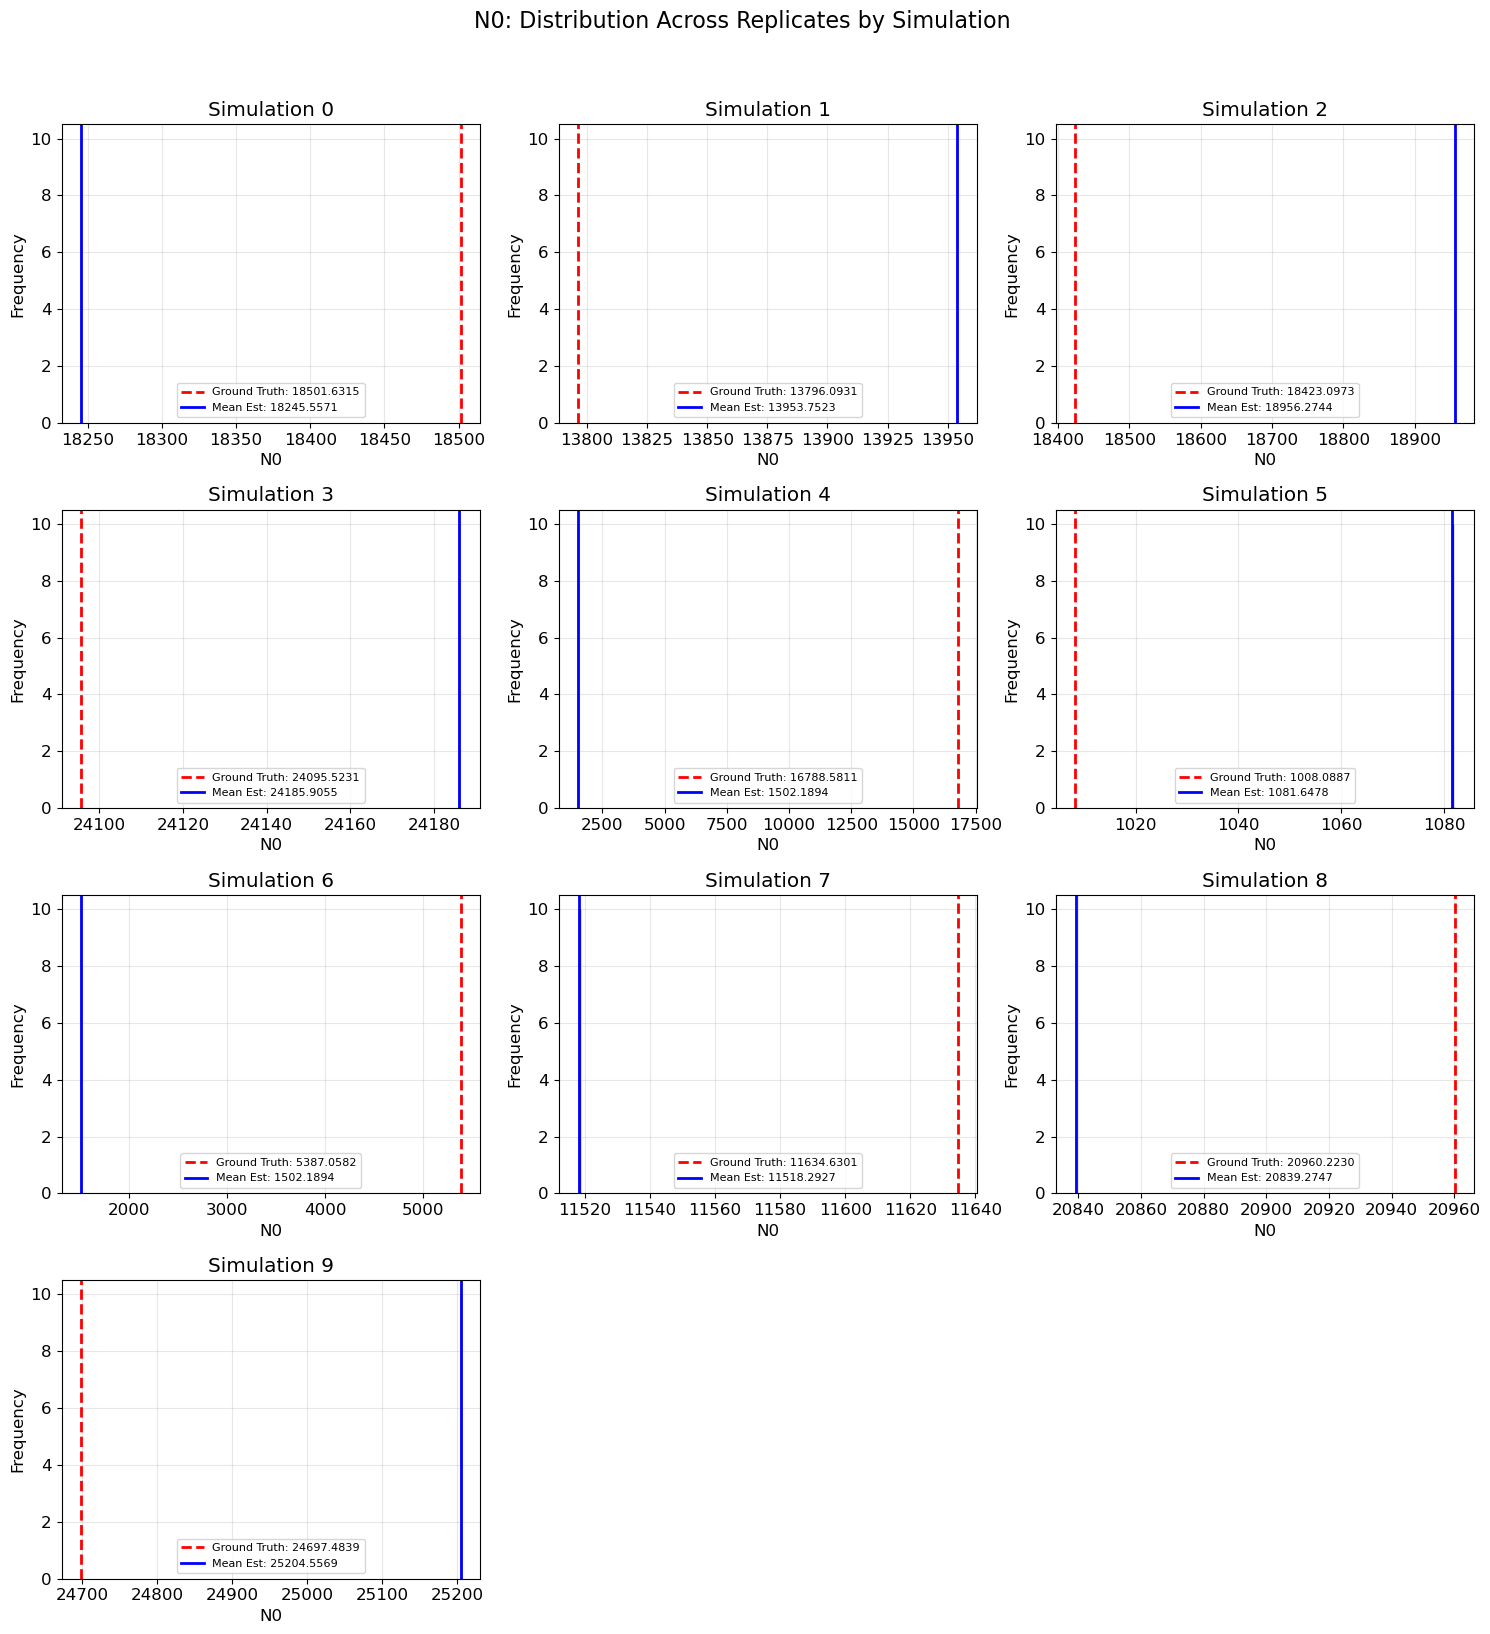

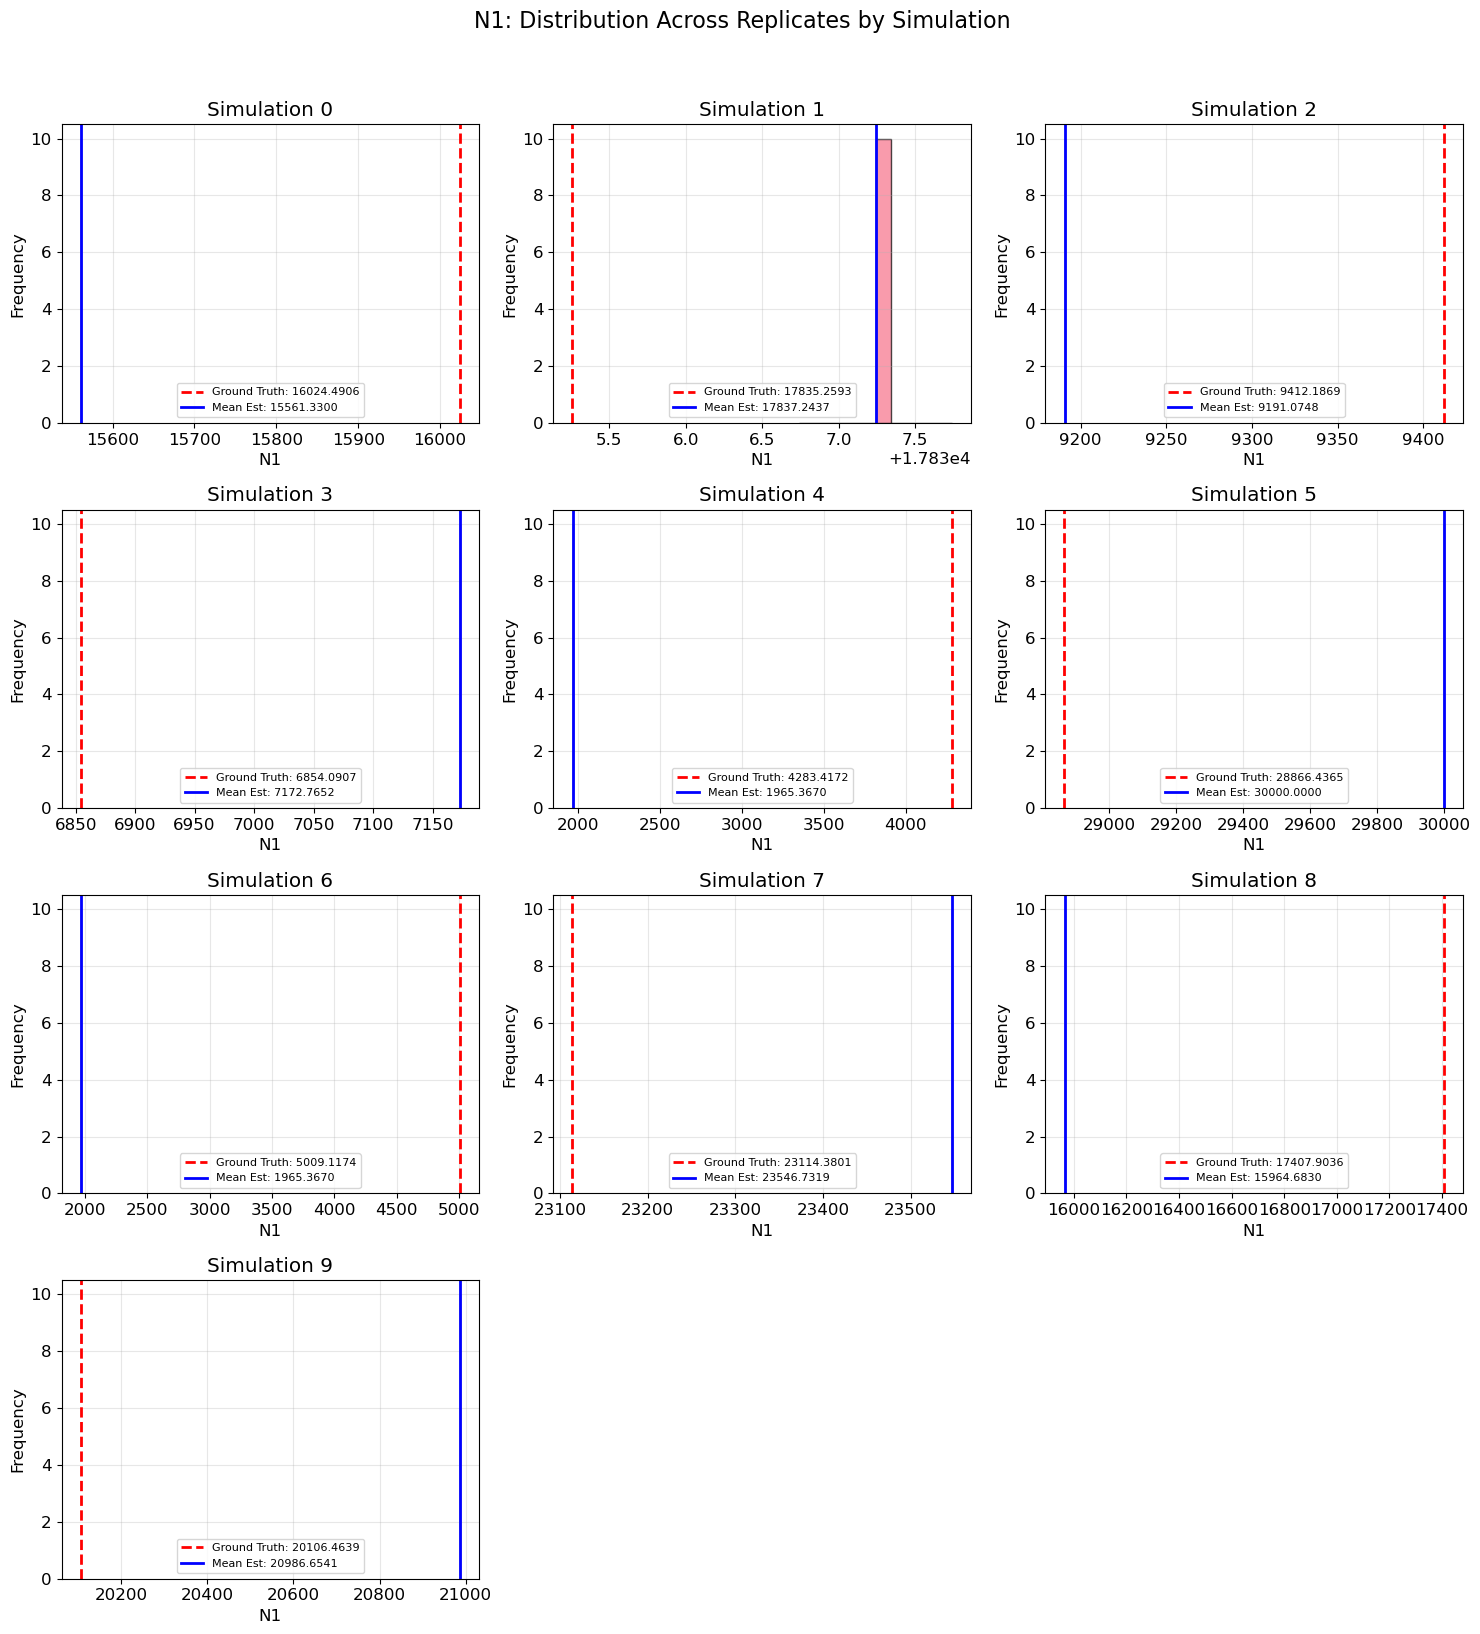

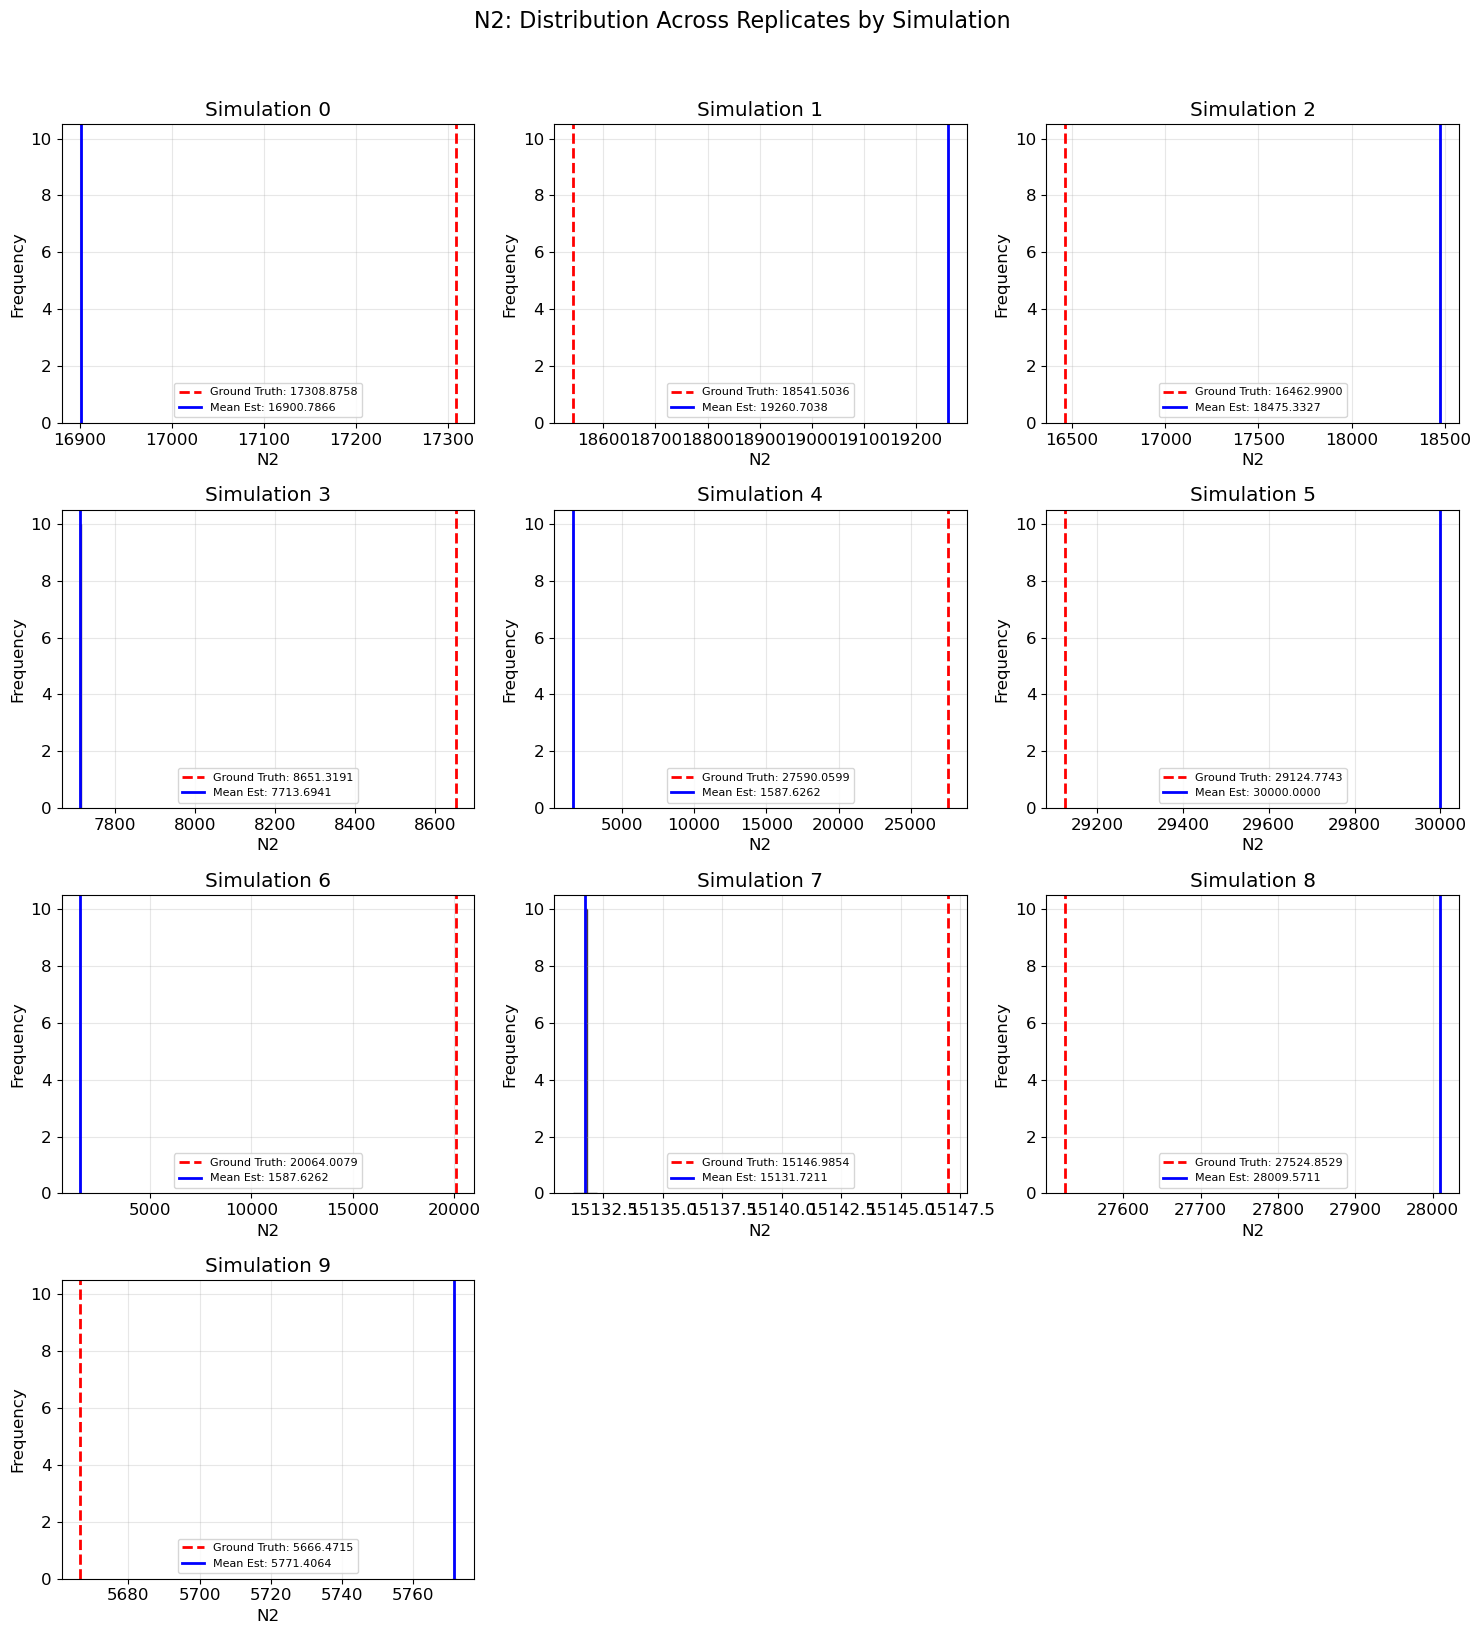

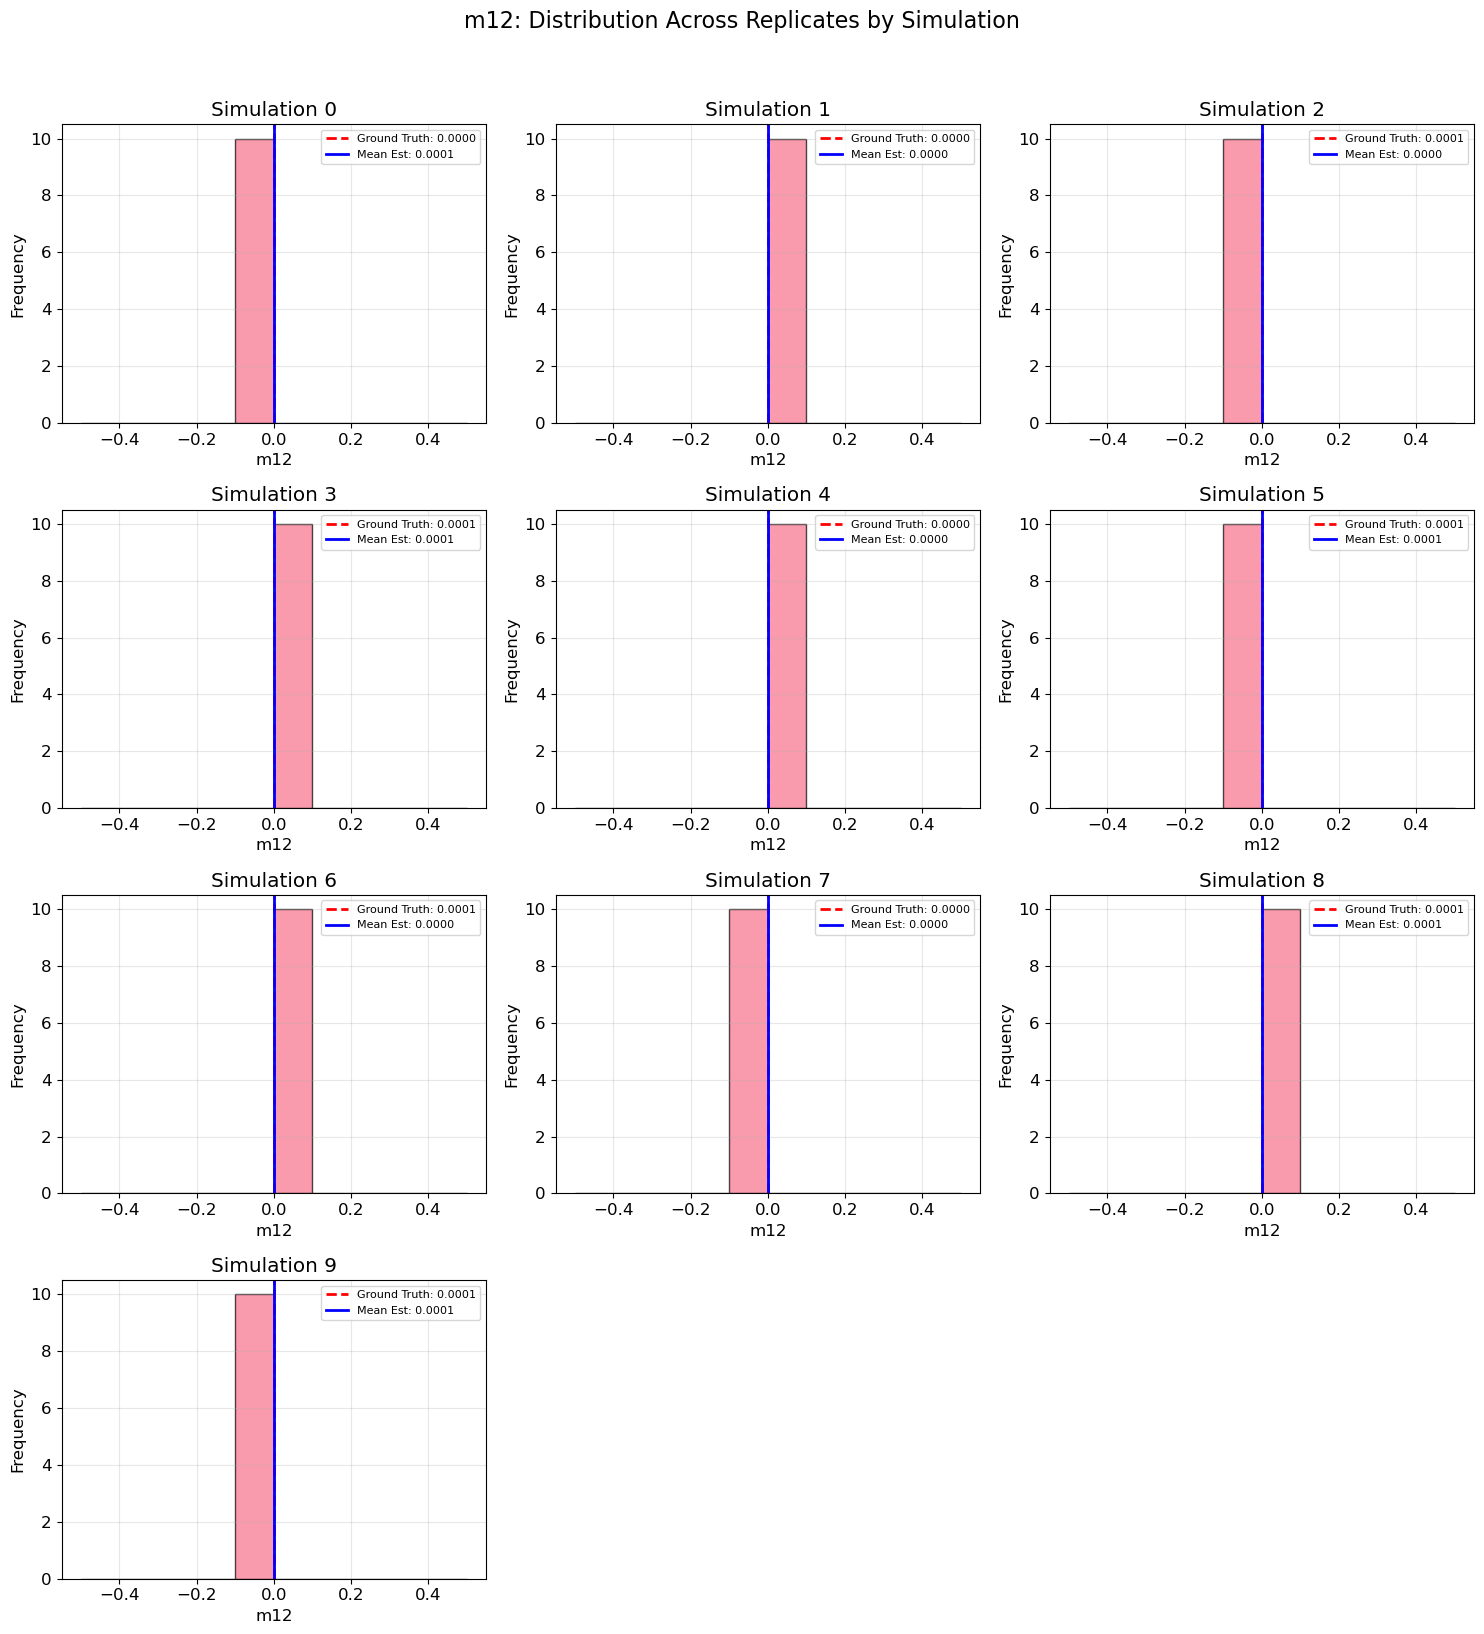

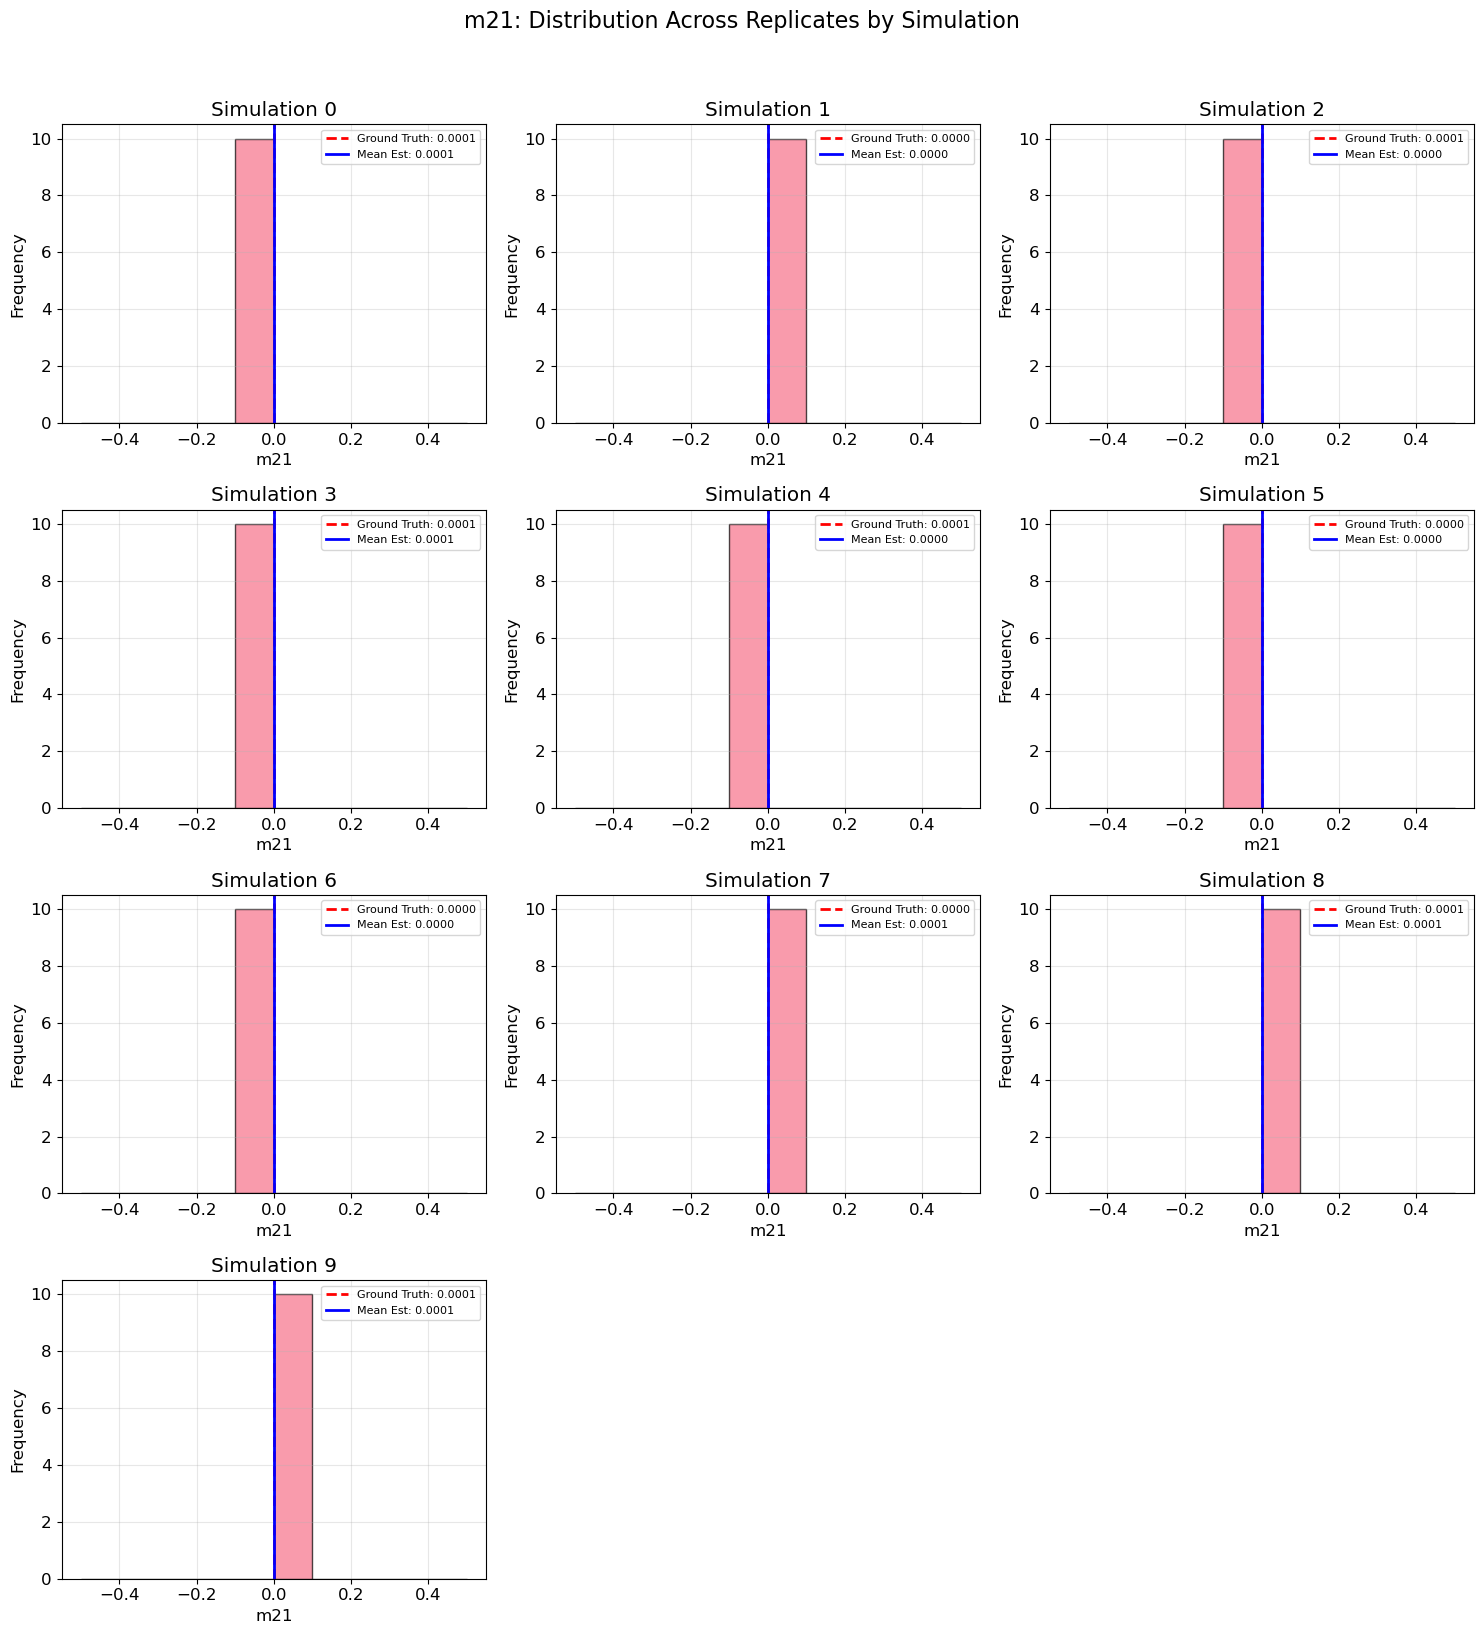

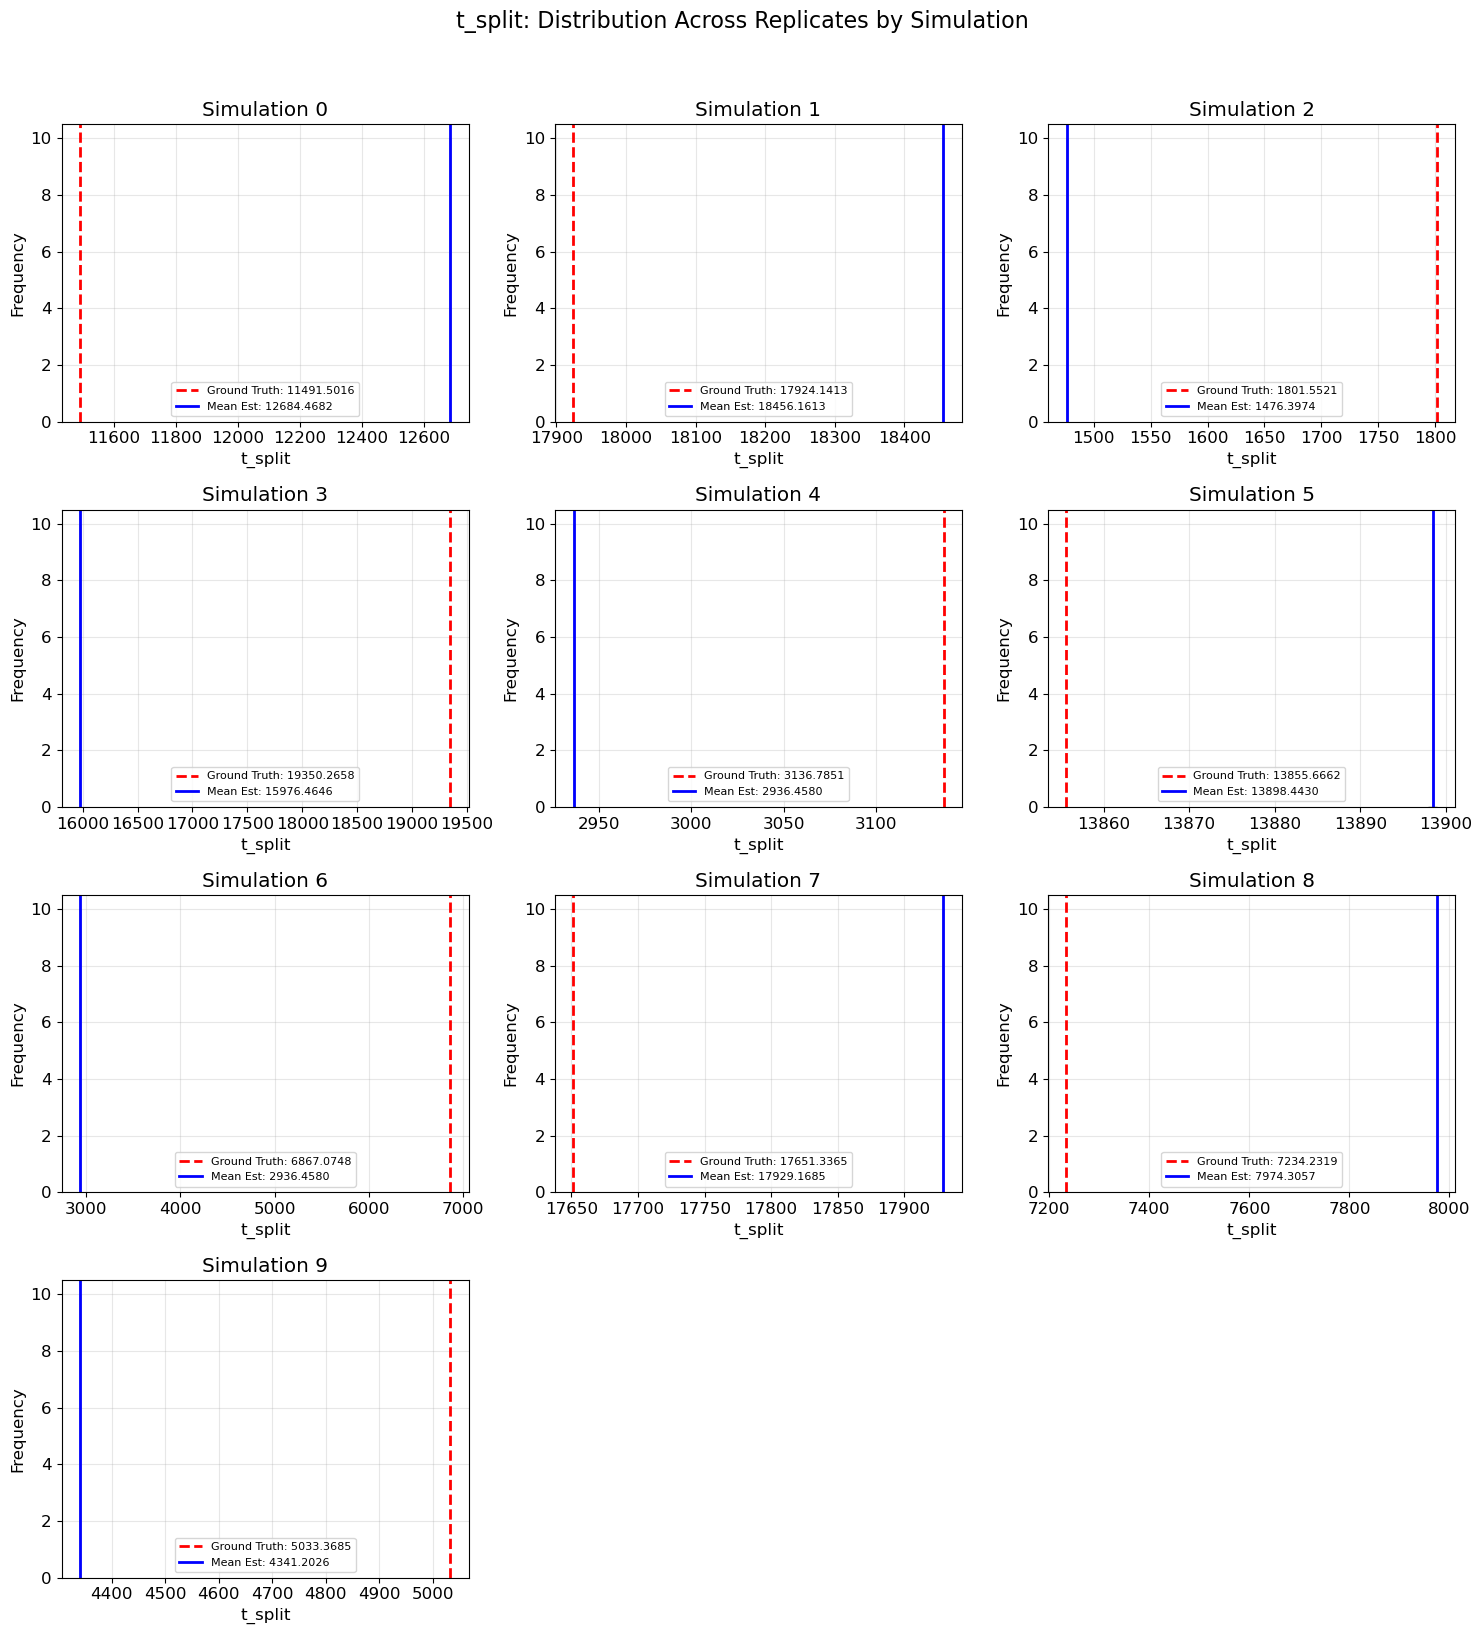

In [ ]:
def plot_parameter_summary_by_simulation(df, parameter_name):
    """Plot summary statistics of estimated parameters across simulations."""
    param_data = df[df['parameter'] == parameter_name]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return
    
    # Sort by simulation ID for proper ordering
    param_data = param_data.copy()
    param_data['sim_int'] = param_data['simulation'].astype(int)
    param_data = param_data.sort_values('sim_int')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Ground truth vs estimated across simulations
    ax1 = axes[0, 0]
    sim_ids = param_data['sim_int']
    ax1.scatter(sim_ids, param_data['ground_truth'], alpha=0.6, s=30, color='red', label='Ground Truth')
    ax1.scatter(sim_ids, param_data['estimated'], alpha=0.6, s=30, color='blue', label='Best Estimate')
    ax1.set_xlabel('Simulation ID')
    ax1.set_ylabel(f'{parameter_name}')
    ax1.set_title(f'{parameter_name}: Ground Truth vs Best Estimates')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Relative error across simulations
    ax2 = axes[0, 1]
    ax2.scatter(sim_ids, param_data['relative_error'], alpha=0.6, s=30, color='green')
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Simulation ID')
    ax2.set_ylabel('Relative Error')
    ax2.set_title(f'{parameter_name}: Relative Error by Simulation')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Distribution of ground truth values
    ax3 = axes[1, 0]
    ax3.hist(param_data['ground_truth'], bins=30, alpha=0.7, edgecolor='black', color='red')
    ax3.set_xlabel(f'Ground Truth {parameter_name}')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'{parameter_name}: Distribution of Ground Truth Values')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Distribution of estimates vs ground truth
    ax4 = axes[1, 1]
    ax4.hist(param_data['estimated'], bins=30, alpha=0.5, edgecolor='black', 
             color='blue', label='Estimates')
    ax4.hist(param_data['ground_truth'], bins=30, alpha=0.5, edgecolor='black', 
             color='red', label='Ground Truth')
    ax4.set_xlabel(f'{parameter_name}')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'{parameter_name}: Distribution Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print quantitative summary
    print(f"\nSummary for {parameter_name} across {len(param_data)} simulations:")
    print(f"  Ground truth range: {param_data['ground_truth'].min():.4f} - {param_data['ground_truth'].max():.4f}")
    print(f"  Estimate range: {param_data['estimated'].min():.4f} - {param_data['estimated'].max():.4f}")
    print(f"  Mean absolute relative error: {param_data['relative_error'].abs().mean():.4f}")
    print(f"  Median absolute relative error: {param_data['relative_error'].abs().median():.4f}")
    print(f"  95th percentile absolute relative error: {param_data['relative_error'].abs().quantile(0.95):.4f}")

def plot_parameter_histograms_by_simulation(df, parameter_name):
    """Plot histograms of estimated parameters for each simulation - modified for many simulations."""
    # For many simulations, this function is less useful, so redirect to summary function
    print(f"With many simulations, showing summary plots instead of individual histograms for {parameter_name}")
    plot_parameter_summary_by_simulation(df, parameter_name)

# Create histograms for all parameters
if 'df_comparison' in locals() and not df_comparison.empty:
    for param in df_comparison['parameter'].unique():
        plot_parameter_histograms_by_simulation(df_comparison, param)
else:
    print("No comparison data available for plotting")

## Statistical Analysis of Parameter Estimates

Calculate summary statistics and assess bias and accuracy relative to ground truth.

Parameter Estimation Statistics:
   parameter simulation  ground_truth  mean_estimate  relative_bias  \
0         N0          0    18501.6315     18245.5571        -0.0138   
1         N0          1    13796.0931     13953.7523         0.0114   
2         N0          2    18423.0973     18956.2744         0.0289   
3         N0          3    24095.5231     24185.9055         0.0038   
4         N0          4    16788.5811      1502.1894        -0.9105   
5         N0          5     1008.0887      1081.6478         0.0730   
6         N0          6     5387.0582      1502.1894        -0.7211   
7         N0          7    11634.6301     11518.2927        -0.0100   
8         N0          8    20960.2230     20839.2747        -0.0058   
9         N0          9    24697.4839     25204.5569         0.0205   
10        N1          0    16024.4906     15561.3300        -0.0289   
11        N1          1    17835.2593     17837.2437         0.0001   
12        N1          2     9412.1869      9

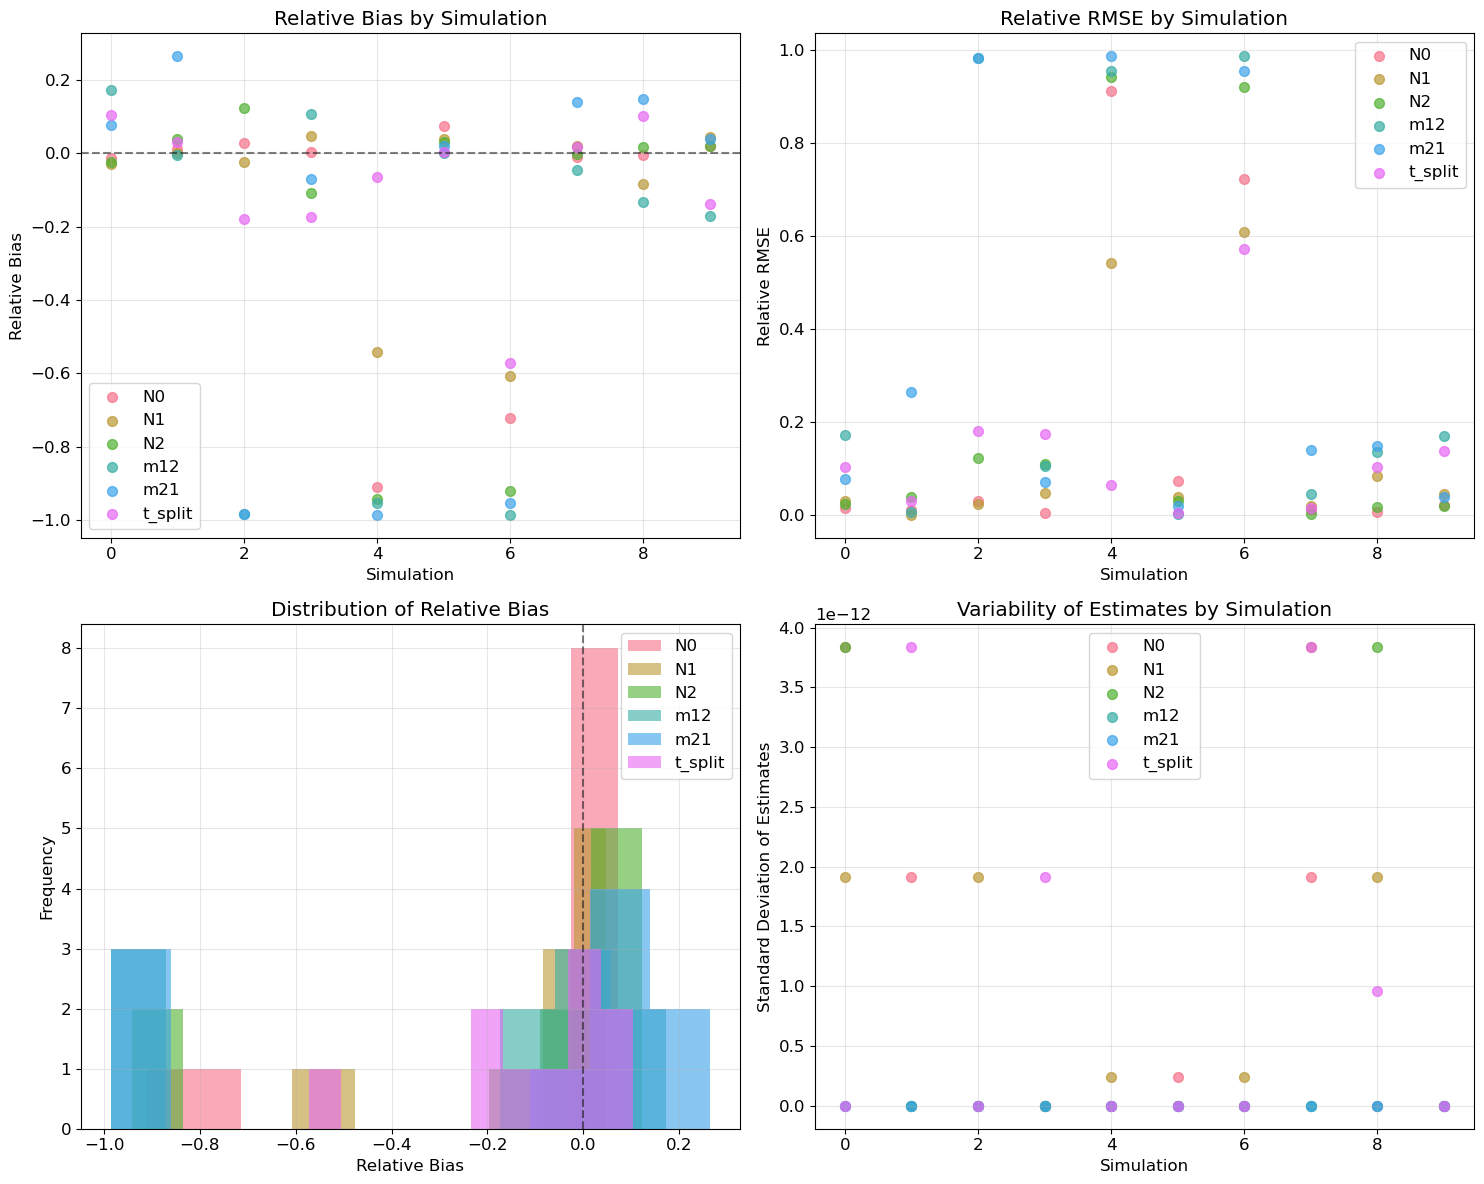



Overall Summary by Parameter:
          relative_bias         relative_rmse         n_replicates
                   mean     std          mean     std          sum
parameter                                                         
N0              -0.1524  0.3534        0.1799  0.3387          100
N1              -0.1136  0.2466        0.1432  0.2288          100
N2              -0.1769  0.4019        0.2223  0.3760          100
m12             -0.3001  0.4761        0.3560  0.4312          100
m21             -0.2307  0.5209        0.3680  0.4242          100
t_split         -0.0874  0.1999        0.1383  0.1649          100


In [ ]:
def calculate_parameter_statistics(df):
    """Calculate comprehensive statistics for parameter estimates."""
    stats_results = []
    
    for param in df['parameter'].unique():
        param_data = df[df['parameter'] == param]
        
        # Since we now have one estimate per simulation (the best one)
        gt_values = param_data['ground_truth']
        estimates = param_data['estimated']
        sim_ids = param_data['simulation']
        
        # Overall statistics across all simulations
        stats_results.append({
            'parameter': param,
            'simulation': 'ALL',
            'n_simulations': len(param_data),
            'mean_ground_truth': gt_values.mean(),
            'std_ground_truth': gt_values.std(),
            'mean_estimate': estimates.mean(),
            'std_estimate': estimates.std(),
            'bias': estimates.mean() - gt_values.mean(),
            'relative_bias': (estimates.mean() - gt_values.mean()) / gt_values.mean(),
            'rmse': np.sqrt(((estimates - gt_values) ** 2).mean()),
            'relative_rmse': np.sqrt(((estimates - gt_values) ** 2).mean()) / gt_values.mean(),
            'mae': np.abs(estimates - gt_values).mean(),
            'relative_mae': np.abs((estimates - gt_values) / gt_values).mean(),
            'correlation': gt_values.corr(estimates),
            'mean_log_likelihood': param_data['log_likelihood'].mean() if 'log_likelihood' in param_data.columns else np.nan
        })
        
        # Also calculate statistics for subsets of simulations if we have many
        if len(param_data) > 20:
            # Calculate statistics for quartiles
            n_sims = len(param_data)
            quartile_size = n_sims // 4
            
            for q, quartile_name in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
                start_idx = q * quartile_size
                if q == 3:  # Last quartile gets remaining simulations
                    end_idx = n_sims
                else:
                    end_idx = (q + 1) * quartile_size
                
                quartile_data = param_data.iloc[start_idx:end_idx]
                gt_q = quartile_data['ground_truth']
                est_q = quartile_data['estimated']
                
                stats_results.append({
                    'parameter': param,
                    'simulation': quartile_name,
                    'n_simulations': len(quartile_data),
                    'mean_ground_truth': gt_q.mean(),
                    'std_ground_truth': gt_q.std(),
                    'mean_estimate': est_q.mean(),
                    'std_estimate': est_q.std(),
                    'bias': est_q.mean() - gt_q.mean(),
                    'relative_bias': (est_q.mean() - gt_q.mean()) / gt_q.mean(),
                    'rmse': np.sqrt(((est_q - gt_q) ** 2).mean()),
                    'relative_rmse': np.sqrt(((est_q - gt_q) ** 2).mean()) / gt_q.mean(),
                    'mae': np.abs(est_q - gt_q).mean(),
                    'relative_mae': np.abs((est_q - gt_q) / gt_q).mean(),
                    'correlation': gt_q.corr(est_q),
                    'mean_log_likelihood': quartile_data['log_likelihood'].mean() if 'log_likelihood' in quartile_data.columns else np.nan
                })
    
    return pd.DataFrame(stats_results)

def plot_bias_analysis(stats_df):
    """Plot bias analysis across parameters."""
    # Filter for overall statistics
    overall_stats = stats_df[stats_df['simulation'] == 'ALL']
    
    if len(overall_stats) == 0:
        print("No overall statistics found for plotting")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Relative bias by parameter
    ax1 = axes[0, 0]
    bars1 = ax1.bar(overall_stats['parameter'], overall_stats['relative_bias'])
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Relative Bias')
    ax1.set_title('Overall Relative Bias by Parameter')
    ax1.grid(True, alpha=0.3)
    # Color bars by sign
    for i, bar in enumerate(bars1):
        if overall_stats.iloc[i]['relative_bias'] < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    # Relative RMSE by parameter
    ax2 = axes[0, 1]
    ax2.bar(overall_stats['parameter'], overall_stats['relative_rmse'])
    ax2.set_ylabel('Relative RMSE')
    ax2.set_title('Overall Relative RMSE by Parameter')
    ax2.grid(True, alpha=0.3)
    
    # Correlation by parameter
    ax3 = axes[1, 0]
    bars3 = ax3.bar(overall_stats['parameter'], overall_stats['correlation'])
    ax3.set_ylabel('Correlation (Ground Truth vs Estimate)')
    ax3.set_title('Ground Truth vs Estimate Correlation')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 1])
    
    # Mean Absolute Error by parameter
    ax4 = axes[1, 1]
    ax4.bar(overall_stats['parameter'], overall_stats['relative_mae'])
    ax4.set_ylabel('Relative Mean Absolute Error')
    ax4.set_title('Overall Relative MAE by Parameter')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot quartile analysis if available
    quartile_stats = stats_df[stats_df['simulation'].isin(['Q1', 'Q2', 'Q3', 'Q4'])]
    if len(quartile_stats) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bias by quartile
        ax1 = axes[0]
        for param in quartile_stats['parameter'].unique():
            param_data = quartile_stats[quartile_stats['parameter'] == param]
            ax1.plot(param_data['simulation'], param_data['relative_bias'], 
                    marker='o', label=param)
        ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax1.set_ylabel('Relative Bias')
        ax1.set_title('Relative Bias by Simulation Quartile')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # RMSE by quartile
        ax2 = axes[1]
        for param in quartile_stats['parameter'].unique():
            param_data = quartile_stats[quartile_stats['parameter'] == param]
            ax2.plot(param_data['simulation'], param_data['relative_rmse'], 
                    marker='o', label=param)
        ax2.set_ylabel('Relative RMSE')
        ax2.set_title('Relative RMSE by Simulation Quartile')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Calculate and display statistics
if 'df_comparison' in locals() and not df_comparison.empty:
    stats_df = calculate_parameter_statistics(df_comparison)
    
    print("Parameter Estimation Statistics (Best Fits Only):")
    print("=" * 60)
    
    # Display overall summary table
    overall_stats = stats_df[stats_df['simulation'] == 'ALL']
    summary_cols = ['parameter', 'n_simulations', 'relative_bias', 'relative_rmse', 'correlation', 'relative_mae']
    if len(overall_stats) > 0:
        print("\nOverall Statistics:")
        print(overall_stats[summary_cols].round(4))
    
    # Plot bias analysis
    plot_bias_analysis(stats_df)
    
    # Display detailed statistics
    print("\n\nDetailed Statistics by Parameter:")
    print("=" * 50)
    for param in overall_stats['parameter']:
        param_stats = overall_stats[overall_stats['parameter'] == param].iloc[0]
        print(f"\n{param}:")
        print(f"  Number of simulations: {param_stats['n_simulations']}")
        print(f"  Mean ground truth: {param_stats['mean_ground_truth']:.4f} ± {param_stats['std_ground_truth']:.4f}")
        print(f"  Mean estimate: {param_stats['mean_estimate']:.4f} ± {param_stats['std_estimate']:.4f}")
        print(f"  Relative bias: {param_stats['relative_bias']:.4f}")
        print(f"  Relative RMSE: {param_stats['relative_rmse']:.4f}")
        print(f"  Relative MAE: {param_stats['relative_mae']:.4f}")
        print(f"  Correlation: {param_stats['correlation']:.4f}")
        if not np.isnan(param_stats['mean_log_likelihood']):
            print(f"  Mean log-likelihood: {param_stats['mean_log_likelihood']:.2f}")
    
else:
    print("No comparison data available for statistical analysis")

## Save Results

Save the comparison data and statistics for future reference.

In [ ]:
# Save results to CSV files
output_dir = Path('/home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results')
output_dir.mkdir(exist_ok=True)

if 'df_comparison' in locals() and not df_comparison.empty:
    # Save comparison data (best fits only)
    comparison_file = output_dir / 'parameter_comparison_best_fits.csv'
    df_comparison.to_csv(comparison_file, index=False)
    print(f"Saved comparison data to: {comparison_file}")
    print(f"  {len(df_comparison)} parameter estimates from {len(df_comparison['simulation'].unique())} simulations")
    
    # Save statistics
    if 'stats_df' in locals():
        stats_file = output_dir / 'parameter_statistics_best_fits.csv'
        stats_df.to_csv(stats_file, index=False)
        print(f"Saved statistics to: {stats_file}")
    
    # Save best estimates summary
    if 'best_estimates' in locals():
        best_estimates_summary = []
        for sim_id, data in best_estimates.items():
            row = {'simulation': sim_id, 'best_replicate': data['best_replicate'], 
                   'log_likelihood': data['log_likelihood']}
            row.update(data['parameters'])
            best_estimates_summary.append(row)
        
        best_df = pd.DataFrame(best_estimates_summary)
        best_file = output_dir / 'best_estimates_summary.csv'
        best_df.to_csv(best_file, index=False)
        print(f"Saved best estimates summary to: {best_file}")
    
    print(f"\nAnalysis complete! Results saved to {output_dir}")
    print(f"Total simulations analyzed: {len(df_comparison['simulation'].unique())}")
    print(f"Parameters analyzed: {list(df_comparison['parameter'].unique())}")
else:
    print("No data to save - check data loading steps above")